<a href="https://colab.research.google.com/github/marziye-jalili/deep_learning/blob/main/cifake_VGG19_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset details**

The dataset contains two classes - REAL and FAKE.

For REAL, we collected the images from Krizhevsky & Hinton's CIFAR-10 dataset

For the FAKE images, we generated the equivalent of CIFAR-10 with Stable Diffusion version 1.4

There are 100,000 images for training (50k per class) and 20,000 for testing (10k per class)

Downloading a Dataset : https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/data

**Upload dataset**

In [ ]:
import zipfile
extract_path = '/content/dataset/'
zip_file_path = '/content/dataset_Real_and_AI_images.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Files extracted successfully!")

Files extracted successfully!


# Libraries used in the model

In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg19 import VGG19
from keras import layers, models, optimizers
from keras.layers import  Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import random

# Load the dataset

In [ ]:
# Define paths to the train and test directories
train_dir_train = '/content/dataset/train'
test_dir_test = '/content/dataset/test'

datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,  # 20% of the data will be used for validation
    rescale=1./255  # Normalization
)
selectedClasses = ['FAKE', 'REAL']
batchSize=256

train_generator = datagen.flow_from_directory(
    train_dir_train,
    target_size=(224, 224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='training',
    shuffle=True,
)

validation_generator = datagen.flow_from_directory(
    train_dir_train,
    target_size=(224, 224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='validation',
    shuffle=True,
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir_test,
    target_size=(224, 224),
    classes=selectedClasses,
    shuffle=False,
    batch_size=batchSize
)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
# Print statistics for train and validation sets
def print_generator_statistics(generator, set_name):
    count = generator.n

    print(f"In {set_name} generator")
    print("Total:\t", count)
    print()

print_generator_statistics(train_generator, "train")
print_generator_statistics(validation_generator, "validation")
print_generator_statistics(test_generator, "test")

In train generator
Total:	 80000

In validation generator
Total:	 20000

In test generator
Total:	 20000



# VGG19

In [ ]:
from tensorflow.keras.utils import get_file

vgg19_weights_path = get_file(
    'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
    'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
    cache_subdir='models',
    file_hash='253f8cb515780f3b799900260a226db6'
)

vgg19_model = VGG19(weights=vgg19_weights_path, include_top=False, input_shape=(224, 224, 3))

# Freeze the first few layers (optional)
for layer in vgg19_model.layers[:5]:
    layer.trainable = False

model_vgg19 = models.Sequential([
    vgg19_model,

    layers.Flatten(),
    layers.Dropout(0.2),

    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(len(selectedClasses), activation='sigmoid')

])

# Compile the VGG19 model with Adam optimizer
model_vgg19.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['accuracy'])

80134624/80134624 [==============================] - 2s 0us/step


In [ ]:
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

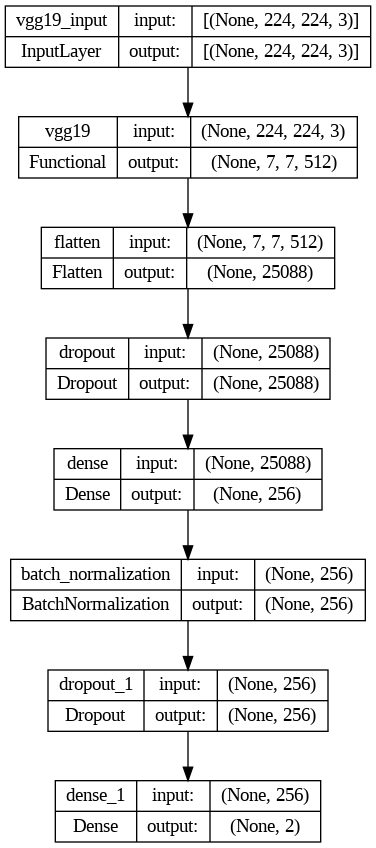

In [ ]:
# Save the model summary to a file
with open('model_summary.txt', 'w') as f:
    model_vgg19.summary(print_fn=lambda x: f.write(x + '\n'))
# Plot the model architecture
plot_model(model_vgg19, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
import time
# Start the training time
# Implement early stopping for VGG19
early_stopping_vgg19 = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
# Implement ReduceLROnPlateau for VGG19
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# Implement TensorBoard for VGG19
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

callbacks = [early_stopping_vgg19, reduce_lr, tensorboard_callback]
history_vgg19 = model_vgg19.fit(train_generator, epochs=12, validation_data=validation_generator, callbacks=callbacks, batch_size=batchSize)


Epoch 1/12
313/313 [==============================] - 1486s 4s/step - loss: 0.2625 - accuracy: 0.8929 - val_loss: 0.6229 - val_accuracy: 0.7625 - lr: 1.0000e-04
Epoch 2/12
313/313 [==============================] - 1347s 4s/step - loss: 0.1718 - accuracy: 0.9335 - val_loss: 0.2253 - val_accuracy: 0.9105 - lr: 1.0000e-04
Epoch 3/12
313/313 [==============================] - 1343s 4s/step - loss: 0.1524 - accuracy: 0.9417 - val_loss: 0.1911 - val_accuracy: 0.9238 - lr: 1.0000e-04
Epoch 4/12
313/313 [==============================] - 1341s 4s/step - loss: 0.1345 - accuracy: 0.9477 - val_loss: 0.1518 - val_accuracy: 0.9402 - lr: 1.0000e-04
Epoch 5/12
313/313 [==============================] - 1333s 4s/step - loss: 0.1291 - accuracy: 0.9504 - val_loss: 0.1231 - val_accuracy: 0.9527 - lr: 1.0000e-04
Epoch 6/12
313/313 [==============================] - 1330s 4s/step - loss: 0.1204 - accuracy: 0.9528 - val_loss: 0.1137 - val_accuracy: 0.9572 - lr: 1.0000e-04
Epoch 7/12
313/313 [==============

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
# Print validation results from training history
print("Validation Loss (last epoch):", history_vgg19.history['val_loss'][-1])
print("Validation Accuracy (last epoch):", history_vgg19.history['val_accuracy'][-1])

Validation Loss (last epoch): 0.08482575416564941
Validation Accuracy (last epoch): 0.9679999947547913


In [ ]:
model_vgg19.save('model_vgg19.keras', save_format='keras')

# Evaluate the model on the test set after saving the model
test_results = model_vgg19.evaluate(test_generator, steps=len(test_generator))
# Print the test set results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


79/79 [==============================] - 90s 1s/step - loss: 0.1306 - accuracy: 0.9513
Test Loss: 0.13061237335205078
Test Accuracy: 0.9512500166893005


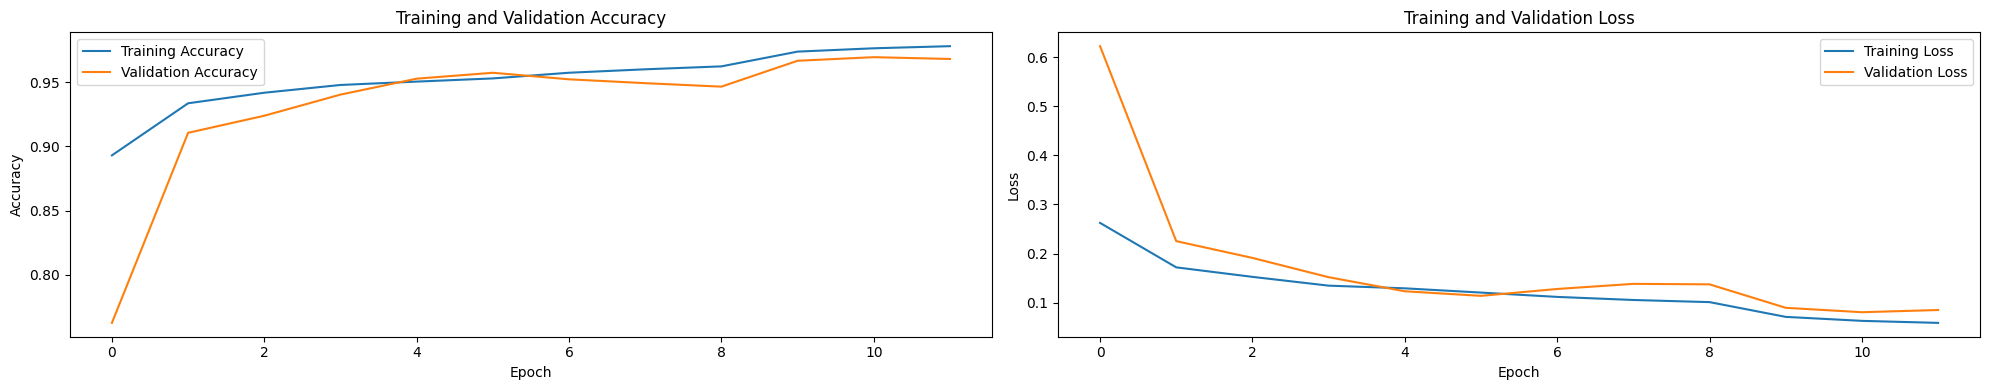

In [ ]:
plt.figure(figsize=(20, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_vgg19.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_vgg19.history['loss'], label='Training Loss')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

79/79 [==============================] - 92s 1s/step


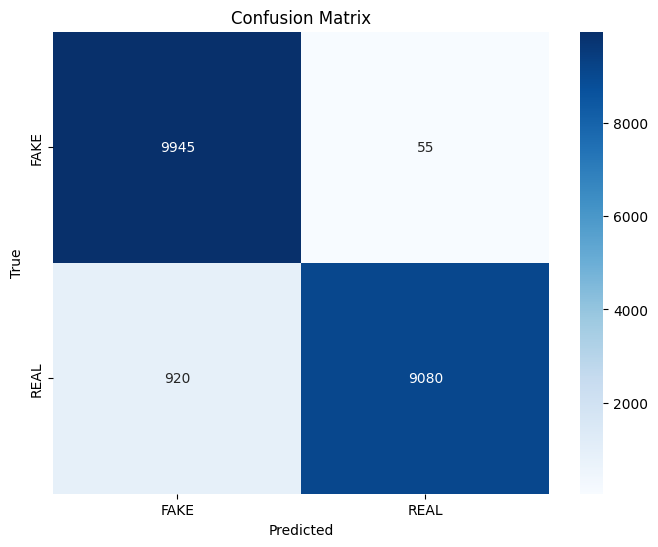

In [ ]:
predictions = model_vgg19.predict(test_generator)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, predictions.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=selectedClasses, yticklabels=selectedClasses)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Display classification report
predictions=model_vgg19.predict(test_generator)
y_pred=np.argmax(predictions,axis=1)
y_true=test_generator.classes
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=selectedClasses))



79/79 [==============================] - 89s 1s/step

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.92      0.99      0.95     10000
        REAL       0.99      0.91      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



1/1 [==============================] - 0s 27ms/step


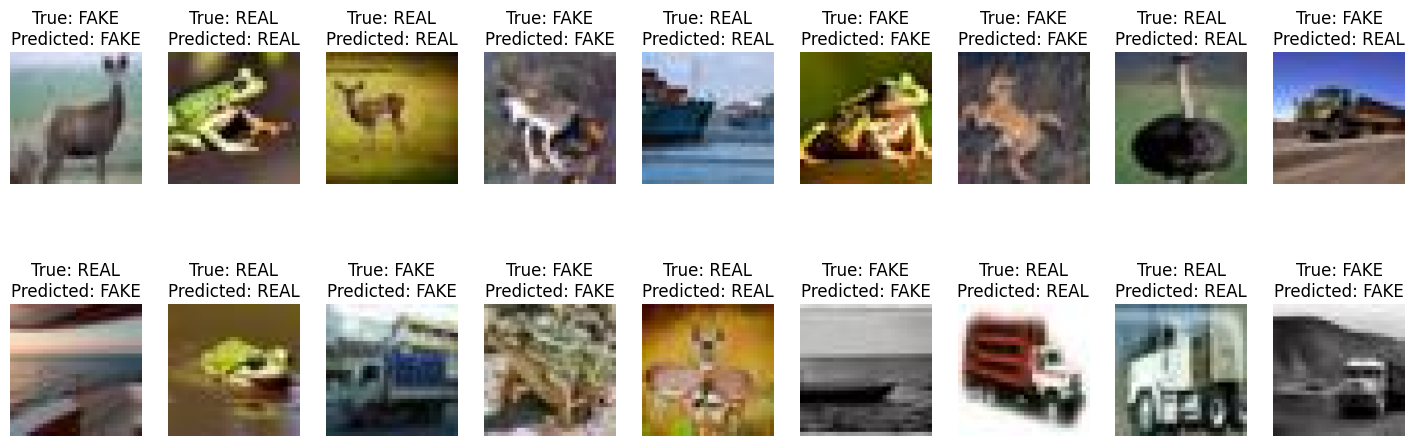

In [ ]:
import random

# Number of random images to display
num_images = 18
# Get random indices from the test set
random_indices = random.sample(range(len(test_generator)), num_images)

# Select random images and their true labels
random_images = [test_generator[i][0][0] for i in random_indices]
random_labels = [test_generator[i][1][0] for i in random_indices]

# Convert true labels to binary
true_labels_binary = (np.array(random_labels) > 0.5).astype(int).reshape(-1, 1)

# Get model predictions for the selected images
predictions = model_vgg19.predict(np.array(random_images))

# Convert model predictions to binary
predicted_labels_binary = (predictions > 0.5).astype(int).reshape(-1, 1)

# Create a grid of subplots with 2 rows and 9 columns
plt.figure(figsize=(18, 6))
for i in range(num_images):
    plt.subplot(2, 9, i + 1)
    plt.imshow(random_images[i])
    plt.axis('off')
    plt.title(f'True: {selectedClasses[true_labels_binary.squeeze()[i]]}\nPredicted: {selectedClasses[predicted_labels_binary.squeeze()[i]]}')

plt.show()
